In [3]:
%load_ext autoreload
%autoreload 2

import casadi as ca
from autodiff_sys import Sys
from helper_fns import *

# Parameters for a closed-loop robot response from desired position to velocity
M = ca.MX.sym('M')
B = ca.MX.sym('B')
Kp = ca.MX.sym('Kp')
Kd = ca.MX.sym('Kd')
R = Sys([Kd,Kp,0],[M,B,Kp])

# Robot delay
#Delay = Sys([1],[1])
Delay = Sys(*pade(1e-3, 3))

# Feedforward control
Kl = ca.MX.sym('Kl')
Cff = Sys([Kl, 0], [1])

# Feedback control + payload comp
B_real  = ca.MX.sym('B_real')
a_vel   = ca.MX.sym('a_vel')
P_hat   = ca.MX.sym('P_hat')
a_acc   = ca.MX.sym('a_acc')

# Feedback controllers
C_s_inv = Sys([B_real*a_vel, 0],[1, a_vel, 0]) # Rob vel to desired position
P_hat_Oa_s_inv = Sys([-P_hat*a_acc*a_vel, 0, 0],[1, a_acc+a_vel, a_acc*a_vel, 0])

# Admittance control params
Ma = ca.MX.sym('Ma')
Ba = ca.MX.sym('Ba')
A = Sys([1], [Ma, Ba, 0])

# Collect the parameters to lists for use later
p = [M, B, Kp, Kd] # fixed params
x = [Kl, Ma, Ba, B_real, a_vel, P_hat, a_acc]   # decision variables
vars = [*p, *x]    # list of all the variables, useful for making casadi functions
x_names = [str(v) for v in x]

##### Building some SYSTEMS ######
# open-loop from F to v
G = R*Delay*(1+Cff)*A

# Feedback from payload comp and control
D = R*Delay*C_s_inv + G*P_hat_Oa_s_inv

# Fd to v with feedback
G_re, _ = (G/(1+D)).get_re_im(vars)

# Environment contact dynamics
K_env = ca.MX.sym('K_env')
M_env = ca.MX.sym('M_env')
E = Sys([M_env, 0, K_env], [1, 0])

# Closed-loop TF
G_cl = G/(1+D+E*G)

# Noise TFs
noise_area_of_concern = Sys([100, 0], [1, 100])
G_nf = Cff*A*noise_area_of_concern
G_nx = (C_s_inv + Cff*A*(P_hat_Oa_s_inv))*noise_area_of_concern

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cancelling pole/zero at 0
Routh Table has leading sym 0; interrupting, may not be complete
Cancelling pole/zero at 0
Cancelling pole/zero at 0
Cancelling pole/zero at 0
Cancelling pole/zero at 0

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      559
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                 

  75 -1.0125182e-03 4.81e-06 1.28e+07   0.6 8.25e+01    -  8.55e-01 3.45e-01w  1
  76 -2.7244694e-03 2.28e-05 1.42e+07   0.6 4.43e+02    -  1.74e-01 4.46e-04h 11
  77 -2.7234547e-03 2.27e-05 1.53e+07   0.6 7.17e+02    -  1.00e+00 4.43e-04h 12
  78 -2.7224476e-03 2.27e-05 1.58e+07   0.6 6.76e+02    -  1.75e-01 4.46e-04h 12
  79 -2.7214353e-03 2.27e-05 1.71e+07   0.6 7.08e+02    -  1.00e+00 4.44e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 -2.7204309e-03 2.27e-05 1.77e+07   0.6 6.65e+02    -  1.76e-01 4.47e-04h 12
  81 -2.7194211e-03 2.27e-05 1.90e+07   0.6 6.99e+02    -  1.00e+00 4.45e-04h 12
  82 -2.7184184e-03 2.27e-05 1.96e+07   0.6 6.60e+02    -  1.78e-01 4.48e-04h 12
  83 -2.7174108e-03 2.27e-05 2.12e+07   0.6 6.91e+02    -  1.00e+00 4.45e-04h 12
  84 -2.7164105e-03 2.27e-05 2.18e+07   0.6 6.52e+02    -  1.79e-01 4.48e-04h 12
  85 -2.7154052e-03 2.27e-05 2.35e+07   0.6 6.83e+02    -  1.00e+00 4.46e-04h 12
  86 -1.1604995e-03 3.06e-06

 168 -2.6548426e-03 2.20e-05 3.11e+08   0.6 6.05e+02    -  1.00e+00 4.53e-04h 12
 169 -2.6538863e-03 2.20e-05 3.16e+08   0.6 5.97e+02    -  2.15e-01 4.53e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 -2.6529281e-03 2.20e-05 3.38e+08   0.6 6.06e+02    -  1.00e+00 4.53e-04h 12
 171 -2.6519726e-03 2.20e-05 3.43e+08   0.6 5.98e+02    -  2.17e-01 4.53e-04h 12
 172 -2.6510153e-03 2.20e-05 3.67e+08   0.6 6.06e+02    -  1.00e+00 4.53e-04h 12
 173 -2.6500605e-03 2.20e-05 3.73e+08   0.6 5.99e+02    -  2.18e-01 4.53e-04h 12
 174 -2.6491040e-03 2.20e-05 3.99e+08   0.6 6.07e+02    -  1.00e+00 4.53e-04h 12
 175 -2.6481500e-03 2.20e-05 4.05e+08   0.6 6.00e+02    -  2.19e-01 4.53e-04h 12
 176 -2.6471942e-03 2.20e-05 4.33e+08   0.6 6.08e+02    -  1.00e+00 4.53e-04h 12
 177 -1.1638324e-03 3.08e-06 1.16e+07   0.6 6.01e+02    -  2.20e-01 9.28e-01w  1
 178 -1.1020664e-03 3.14e-06 3.02e+08   0.6 6.38e+02    -  1.16e-01 2.05e-01w  1
 179 -1.0590607e-03 3.42e-06

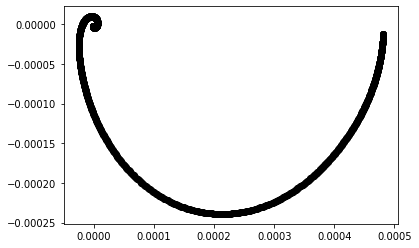

In [4]:
# Optimize!

# Initial values and bounds
p0  = [5, 120, 400, 100] # numerical value of params
x0  = [0.02, 12,  1500,  0.01, 20, 18, 10]  # initial guess at dec vars
vars0 = [*p0, *x0]
ubx = [0.06,  30, 3000,  10.0,  60,  40,  60]  # upper bound
lbx = [ 0.0,   5,  100,  0.0,  0.0,  0.0, 0.0]# lower bound

# Design bounds; can be tuned
noise_bound_f = 1e-2
noise_bound_x = 1e-1
passivity_bound = -3e-6
rt_stability_bound = 1e-8
h2_solver = 'scipy' # scipy or lapackqr or ...

# OBJECTIVE: J will be minimized, to maximize admittance F->v
J = -G.h2(sol = h2_solver) 
#J = J.monitor('Obj') # Will print the evaluations
# CONSTRAINTS
g = []
ubg = []
lbg = []

# OL Stability:

rt = routh_table(G.den)
for r_i in range(1, len(rt)):
    g0 =ca.Function('test', vars, [rt[r_i]])
    #print('OL RT at vars0: {}'.format(g0(*vars0)))
    g.append(rt[r_i]/g0(*vars0))
    ubg.append(np.Inf)
    lbg.append(rt_stability_bound) 


# Contact Stability:
# Require stability for each of several environment conditions
for K_en in [5e5]:
    #Stab
    #E = Sys([M_en, 0, K_en], [1, 0])
    E = Sys([K_en], [1, 0])
    G_cl = G/(1+D+E*G)
    rt = routh_table(G_cl.den)
    for r_i in range(1, len(rt)):
        g0 =ca.Function('test', vars, [rt[r_i]])
        #print('CL RT at vars0: {}'.format(g0(*vars0)))
        g.append(rt[r_i]/g0(*vars0))
        ubg.append(np.Inf)
        lbg.append(rt_stability_bound)    

#Noise
g.append(G_nf.h2(sol = h2_solver))
ubg.append(noise_bound_f)
lbg.append(-np.Inf)
    
g.append(G_nx.h2(sol = h2_solver))
ubg.append(noise_bound_x)
lbg.append(-np.Inf)

for om in np.logspace(0.1, 4, num = 50):
    imag_pt = G_re(om, *p0, *x)
    #imag_pt = imag_pt.monitor('imag')
    g.append(imag_pt)
    lbg.append(passivity_bound)
    ubg.append(np.Inf)
       
opts = { #'ipopt.tol': 1e-3,
         'ipopt.max_iter': 200,
         #'ipopt.constr_viol_tol': 1e-9,                 # Allowable violation of constraint, default 1e-8
         'ipopt.print_level': 5,                         # Change the amount of output from IPOPT
         #'ipopt.derivative_test': 'second-order',       # Check the gradient by numerical differntiation
         'ipopt.mu_strategy': 'monotone',                # Determines which barrier parameter update strategy is to be used. Default "monotone", can choose 'adaptive' instead
         'ipopt.mu_init' : 1e2,                          # Initial value for the barrier parameter (mu). It is only relevant in the monotone, Fiacco-McCormick version of the algorithm.
         'ipopt.bound_relax_factor' : 0,                 # Relaxes constraints, default 1e-8, can cause problems here, eg if params go negativ
         'ipopt.expect_infeasible_problem' : 'yes',      # Starts ipopt to solve for feasiblity (i.e. satisfy constraints)
       }
        
# J is objective, w decision vars, g constraints (subject to ubg and lbg)
prob = dict(f = J, x = ca.vertcat(*x), g = ca.vertcat(*g), p = ca.vertcat(*p))
solver = ca.nlpsol('solver', 'ipopt', prob, opts)
args = dict(x0 = x0, lbx = lbx, ubx = ubx, ubg = ubg, lbg = lbg, p = p0)
sol = solver(**args)
x_opt = sol['x'].full().tolist()
for val, nam in zip(x_opt, x_names):
    print('{:7s} : {:.3f}'.format(nam, val[0]))

G.nyquist(vars, [*p0, *sol['x'].full()], om_range = [0.1, 4])

In [5]:
# TESTING: Checking the poly solving
om = ca.MX.sym('om')
om0 = ca.MX.sym('om0')
poly = ca.polyval(ca.vertcat(*G.den), om)
poly_fn = ca.Function('poly', [om, *vars], [poly])
poly_fn0 = poly_fn(om, *vars)
roots = ca.rootfinder('rts', 'newton', poly_fn)
print(roots(-0.0, *vars0))


-4


In [6]:
# TESTING: Scaling the objective
J_fn = ca.Function('J_fn', [*vars], [J])
J0 = J_fn(*p0, *x0)
#J *= 1/ca.fabs(J0)
#J_grad_fn = ca.Function('J_grad_fn', [*vars], [ca.gradient(J, ca.horzcat(*x))])
print('Objective: {}'.format(J0))
#print('Gradient:  {}'.format(J_grad_fn(*p0, *x0)))

Objective: -0.00276818
